In [41]:
# Use of SOFT-SOURCE here

import numpy as np, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# defining the simulation volume
nm = 1e-9
size = 10000*nm
dz = 10*nm
Nz = (int) (size//dz)
Nt = 5000

# constants
# epsilon_r = 1 #vacuum
epsilon_0 = 8.85e-12 #free space permittivity
c0 = 3e8
sigma = 0 #non-conductive media being considered

# time step via Courant condition
dt = dz/(2*c0) 

# initialising E and B throughout the space grid as 0
E = np.zeros(Nz)
B = np.zeros(Nz)

Lambda = 800*nm #Ti-Sa laser being considered
omega = 2*np.pi*c0/Lambda # frequency

source_pos = 200
E0 = 1

In [42]:
# defining the glass slab - change of definition of the epsilon_r from constant to array
epsilon_r = np.ones(Nz) # vaccuum space

slabs_start = 300
N_pairs = 20

k_start = slabs_start
for N in range (1, N_pairs+1):
    epsilon_r[k_start:k_start+8] = 2.5**2 # TiO2 
    epsilon_r[k_start+8:k_start+21] = 1.5**2 # SiO2
    # thicknesses obtained from the calculation of DBR mathematics 
    k_start+=21
    

In [43]:
# Obtaining a comparison between of the Amplitude of reflected and transmitted parts



# variables to capture the time trace of amplitudes
ref_probe = 100
trans_probe = 900
E_ref_probe = np.zeros(Nt)
E_trans_probe = np.zeros(Nt)





with PdfPages(f'#3_DBR_{N_pairs}.pdf') as pdf:
    E_left =0
    B_right=0
    for n in range(0, Nt): # 1:Nmax time steps
        
        # capturing the of reflection and transmission amplitudes
        E_ref_probe[n] = E[ref_probe] 
        E_trans_probe[n] = E[trans_probe]
        
        
        temp = E[1] # for the left side of the grid
        for k in range (1,Nz): # 2:last
            const1 = (1-(sigma*dt)/(2*epsilon_0*epsilon_r[k]))
            const2 = (1+(sigma*dt)/(2*epsilon_0*epsilon_r[k]))
            
            E[k] = (const1* E[k] - (c0**2*dt)/(epsilon_r[k]*dz)*(B[k]-B[k-1]))/const2  
            
        E[source_pos] += E0*np.sin(omega*n*dt)
        
        E[0] = E_left
        E_left = temp
            
        temp = B[-2] # for the right side of the grid
        for k in range(0,Nz-1): # 1:last-1
            B[k] = B[k] - dt/dz*(E[k+1] - E[k])
        
        B[-1] = B_right
        B_right = temp
            
        
        if n%100==0:
            #creating a new figure
            fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column
            
            # Plot each array on a subplot
            axs[0].plot(E, "-k", label="E-field")
            axs[0].set_title(f'For Dielectric Slab; At the timestep {n}')
            axs[0].set_ylim(-4, 4)  # Optional: Set y-axis limits if needed
            axs[0].axvline(x=ref_probe,color="r")
            axs[0].axvline(x=trans_probe,color="g")
            axs[0].axvline(x = source_pos, color= "k")
            axs[0].grid(True)
            
            k_start = slabs_start
            for N in range (1, N_pairs+1): # color the layers
                axs[0].axvspan(k_start, k_start+8, color='b', alpha=0.4)
                axs[0].axvspan(k_start+8, k_start+21, color='b', alpha=0.2)
                k_start += 21
            

            axs[1].plot(E_ref_probe, color="r")
            axs[1].set_title(f'Reflection Amplitude E[{ref_probe}]; At timestep {n}')
            axs[1].grid(True)
            axs[1].set_ylim(-2.5,2.5)

            axs[2].plot(E_trans_probe, color="g")
            axs[2].set_title(f'Transmission Amplitude E[{trans_probe}]; At timestep {n}')
            axs[2].grid(True)
            axs[2].set_ylim(-2.5, 2.5)
        
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)  
            

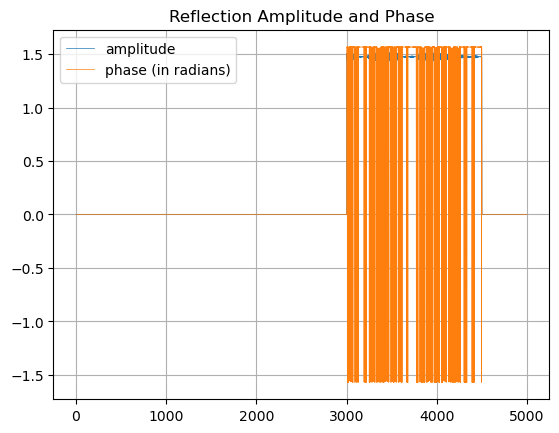

In [44]:
# Extraction of Phase (and amplitude) - for REFLECTED PART ONLY

amplitude = np.zeros(Nt)
phase = np.zeros(Nt)

for i in range (3000, 4500):
    j = i+1
    A = np.array([[np.sin(omega*j*dt), np.cos(omega*j*dt)], [np.sin(omega*i*dt), np.cos(omega*i*dt)]])
    b = np.array([E_ref_probe[j], E_ref_probe[i]])
    
    x = np.linalg.solve(A, b)
    
    amplitude[i] = np.sqrt(x[0]**2+x[1]**2)
    phase[i] = np.arctan(x[1]/x[0])
    
plt.plot(amplitude, label="amplitude", linewidth =0.5)
plt.plot(phase, label="phase (in radians)", linewidth = 0.5)
plt.grid()
plt.title("Reflection Amplitude and Phase")
plt.legend()


In [45]:
# Calculation of the reflectivity
# absolute reflected amplitude = interefered ampltitude - incident amplitude

E_inc = 1 # E0
E_ref = np.mean(amplitude[3000:4500])-E_inc

R = (E_ref/E_inc)**2

print(f"For N={N_pairs}, Reflectivity = {R*100}%")



For N=1, Reflectivity = 22.517540654824423%


In [46]:
# Extraction of Phase (and amplitude) - for TRANSMITTED PART ONLY

# amplitude = np.zeros(Nt)
# phase = np.zeros(Nt)

# for i in range (2000, 4500):
#     j = i+1
#     A = np.array([[np.sin(omega*j*dt), np.cos(omega*j*dt)], [np.sin(omega*i*dt), np.cos(omega*i*dt)]])
#     b = np.array([E_trans_probe[j], E_trans_probe[i]])
    
#     x = np.linalg.solve(A, b)
    
#     amplitude[i] = np.sqrt(x[0]**2+x[1]**2)
#     phase[i] = np.arctan(x[1]/x[0])
    
# plt.plot(amplitude, label="amplitude", linewidth =0.5)
# plt.plot(phase, label="phase (in radians)", linewidth = 0.5)
# plt.grid()
# plt.title("Transmission Amplitude and Phase")
# plt.legend()
